In [59]:
from keras.src.callbacks import EarlyStopping

from database_io import *
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from scipy import optimize as optim


In [60]:
# path of databases (must exist)
db_path = "db/"

# filenames of databases (this must be sqlite3 databases)
train_fname = "surf17_train.db"
validation_fname = "surf17_validation.db"
test_fname = "surf17_test.db"

dim_syndr = 8
dim_fsyndr = 4
n_steps_net1 = 20
n_steps_net2 = 3

data = DatabaseIO(dim_syndr, dim_fsyndr, n_steps_net1, n_steps_net2)

In [ ]:
try:
    data.close_databases()
except:
    pass
data.load_data(db_path + train_fname, db_path + validation_fname, db_path + test_fname)



batch_size = 64
n_batches_train = 1000
n_batches_validation = 100



class DecoderSequence(Sequence):
    def __init__(self, data, batch_size, n_batches, data_type):
        self.data = data
        self.batch_size = batch_size
        self.n_batches = n_batches
        self.data_type = data_type
        self.on_epoch_end()

    def __len__(self):
        return self.n_batches

    def __getitem__(self, idx):
        # return the idx-th batch captured at epoch start
        return self.epoch_batches[idx]

    def on_epoch_end(self):
        """Called automatically by Keras at the end of each epoch."""
        gen = self.data.gen_batches(
            self.batch_size,
            self.n_batches,
            data_type=self.data_type
        )

        self.epoch_batches = []
        for _ in range(self.n_batches):
            batch_x1, batch_x2, batch_fx, batch_l1, batch_l2, batch_y = next(gen)

            # Wrap into Keras multi-input format
            inputs = (batch_x1, batch_x2, batch_fx) #, batch_l1, batch_l2)
            outputs = batch_y
            self.epoch_batches.append((inputs, outputs))

train_seq = DecoderSequence(
    data,
    batch_size=batch_size,
    n_batches=n_batches_train,
    data_type='training'
)

val_seq = DecoderSequence(
    data,
    batch_size=batch_size,
    n_batches=n_batches_validation,
    data_type='validation'
)


loaded databases and checked exclusiveness training, validation, and test keys
N_training=400000, N_validaiton=10000, N_test=5000.


In [62]:
# DEFINING THE MODEL
x1 = Input(shape=(None, dim_syndr), name="x1_full")
x2 = Input(shape=(n_steps_net2, dim_syndr), name="x2_recent")
fx = Input(shape=(dim_fsyndr,), name="final_increment")

x1_masked = layers.Masking(mask_value=0.0)(x1)

dropout_rate = 0.2
layer_width = 64

# Network 1 (full syndrome history)
h1 = layers.LSTM(layer_width, activation="tanh", return_sequences=True, kernel_regularizer=keras.regularizers.l2(1e-5))(x1_masked)
h1 = layers.Dropout(dropout_rate)(h1)
h1 = layers.LSTM(layer_width, activation="tanh", kernel_regularizer=keras.regularizers.l2(1e-5))(h1)
h1 = layers.Dropout(dropout_rate)(h1)
p1 = layers.Dense(layer_width, activation="relu", name="p1", kernel_regularizer=keras.regularizers.l2(1e-5))(h1)
p1 = layers.Dropout(dropout_rate)(p1)
p1 = layers.Dense(1, activation="sigmoid", kernel_regularizer=keras.regularizers.l2(1e-5), name="p1_prob")(p1)


# Network 2 (recent syndrome + final increment)
h2 = layers.LSTM(layer_width, activation="tanh", kernel_regularizer=keras.regularizers.l2(1e-5), return_sequences=True)(x2)
h2 = layers.Dropout(dropout_rate)(h2)
h2 = layers.LSTM(layer_width, activation="tanh", kernel_regularizer=keras.regularizers.l2(1e-5))(h2)
h2 = layers.Dropout(dropout_rate)(h2)

p2 = layers.Concatenate()([h2, fx])
p2 = layers.Dense(layer_width, activation="relu", name="p2", kernel_regularizer=keras.regularizers.l2(1e-5))(p2)
p2 = layers.Dropout(dropout_rate)(p2)
p2 = layers.Dense(1, activation="sigmoid", name="p2_prob", kernel_regularizer=keras.regularizers.l2(1e-5))(p2)


# Final combination p = probabilistic sum
p_final = layers.Lambda(lambda x: x[0]*(1-x[1]) + x[1]*(1-x[0]))([p1, p2]) # XOR Gate

model = Model(inputs=[x1, x2, fx], outputs=p_final)
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ x1_full             │ (None, None, 8)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_5         │ (None, None, 8)   │          0 │ x1_full[0][0]     │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ x2_recent           │ (None, 3, 8)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking_5 (Masking) │ (None, None, 8)   │          0 │ x1_full[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any_5 (Any)         │ (None, None)      │          0 │ not_equal_5[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_22 (LSTM)      │ (None, 3, 64)     │     18,688 │ x2_recent[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_20 (LSTM)      │ (None, None, 64)  │     18,688 │ masking_5[0][0],  │
│                     │                   │            │ any_5[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_33          │ (None, 3, 64)     │          0 │ lstm_22[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_30          │ (None, None, 64)  │          0 │ lstm_20[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_23 (LSTM)      │ (None, 64)        │     33,024 │ dropout_33[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_21 (LSTM)      │ (None, 64)        │     33,024 │ dropout_30[0][0], │
│                     │                   │            │ any_5[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_34          │ (None, 64)        │          0 │ lstm_23[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ final_increment     │ (None, 4)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_31          │ (None, 64)        │          0 │ lstm_21[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 68)        │          0 │ dropout_34[0][0], │
│ (Concatenate)       │                   │            │ final_increment[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p1 (Dense)          │ (None, 64)        │      4,160 │ dropout_31[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p2 (Dense)          │ (None, 64)        │      4,416 │ concatenate_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_32          │ (None, 64)        │          0 │ p1[0][0]          │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_35          │ (None, 64)        │          0 │ p2[0][0]        

 Total params: 112,130 (438.01 KB)

 Trainable params: 112,130 (438.01 KB)

 Non-trainable params: 0 (0.00 B)

In [63]:
# COMPILING AND TRAINING THE MODEL
model.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(1e-3),
    metrics=["accuracy"]
)

num_epochs = 1000

checkpoint = ModelCheckpoint(
    'best_model.keras',        # file path to save the model
    monitor='val_accuracy',    # metric to monitor
    verbose=1,                 # prints message when saving
    save_best_only=True,       # only save if improved
    mode='max'                 # 'min' for loss, 'max' for accuracy
)

early_stop = EarlyStopping(
    monitor='val_loss',        # use validation loss to monitor
    patience=50,                # stop after n epochs with no improvement
    min_delta=1e-4,            # threshold for minimum change over epochs -> "no imporovement"
    restore_best_weights=True, # keeps weights from the best epoch
    verbose=1
)


results = model.fit(
    train_seq,
    steps_per_epoch=n_batches_train,
    epochs=num_epochs,
    verbose=1,
    validation_data=val_seq,
    validation_steps=n_batches_validation,
    callbacks=[checkpoint, early_stop]
)

c:\Users\jacky\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/1000


ValueError: Layer "functional_5" expects 3 input(s), but it received 4 input tensors. Inputs received: [<tf.Tensor 'data:0' shape=(None, 20, 8) dtype=bool>, <tf.Tensor 'data_1:0' shape=(None, 3, 8) dtype=bool>, <tf.Tensor 'data_2:0' shape=(None, 4) dtype=bool>, <tf.Tensor 'data_3:0' shape=(None,) dtype=int32>]

In [ ]:
# stat calculation taken from original code

def decay(x, p_logical, x0):
  """ This functions is used to make a exponential fit to the fidelity
      curves """
  return (1 + (1 - 2 * p_logical)**(x - x0)) / 2.

def calc_stats(data, n_sampling=5000, x0_max=10, verbose=False):
    """ calculates the logical error rate and error bars """

    # since it is possible that the batch does not contain fidelities
    # for all steps, hence we need a list with all steps for which
    # predictions excist (we call it 'steps')
    steps, data_nonzero = [], []
    fids, rs_means_l, plogs_bs = [], [], []

    # in the following we assume that the first step is s = 1
    for s in range(1, len(data) + 1):
        dat = data[s - 1]
        if len(dat) != 0:
            # non-trivial data points
            steps.append(s)
            data_nonzero.append(dat)
            # fidelities
            fids.append(np.mean(dat))

    # fit decay curve to the non-tivial data
    popt, pcov = optim.curve_fit(
        decay, steps, fids, bounds=((0.0001, 0.0001), (.1, x0_max)))
    plog, x0 = popt[0], popt[1]
    if x0 > 0.99 * x0_max:
        print("WARNING, x0 is larger than", x0_max,
            "the fitting algorithm fails")
    if plog > .09:
        print("WARNING, plog is larger than 9%, the fitting algorithm fails")

    

    res_dict = {'steps': steps, 'fids': fids, 'plog': plog, 'x0': x0}
    if verbose:
        print("logical error rate:", round(plog * 100, 5), "%")
        print("x0 offset", round(x0, 3))

    return res_dict


num_samples = 1000


batch = None
for gen in data.gen_batches(num_samples, 1, data_type='test'):
    batch = gen
x1, x2, fx, l1, _, y_actual = batch
y_prob = model.predict((x1,x2,fx,l1))


969/969 ━━━━━━━━━━━━━━━━━━━━ 77s 78ms/step


(501,)
logical error rate: 0.66124 %
x0 offset 3.797
Accuracy: 0.6610967741935484


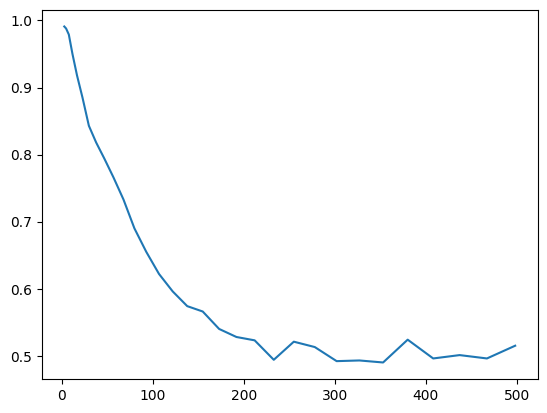

In [ ]:
y_preds_bool = np.empty_like(y_actual)
l_arr = np.array(range(501))
errors = np.zeros_like(l_arr)
samples = np.zeros_like(l_arr)
for idx in range(y_actual.size):
    samples[l1[idx]] += 1
    y_pred = y_prob[idx] > 0.5
    y_preds_bool[idx] = y_pred
    if (y_pred != y_actual[idx]) :
        errors[l1[idx]] += 1

comp_list = np.equal(y_preds_bool, y_actual).astype('float')
comparison = []
for n in range(max(l1)):
    comparison.append([])
for n in range(len(comp_list)):
    idx = l1[n] - 1
    comparison[idx].append(comp_list[n])
stats_dict = calc_stats(comparison, n_sampling=5000, x0_max=10, verbose=True)
fidelity = np.divide(samples - errors, samples, out=np.zeros_like(errors, dtype=float), where=(samples != 0)).astype(float)

x, y = [], []
for idx in range(len(fidelity)):
    if (fidelity[idx] != 0):
        x.append(l_arr[idx])
        y.append(fidelity[idx])

plt.plot(x, y)
plt.ylabel("Logical Fidelity")
plt.xlabel("Cycles")

print(f"Overall Accuracy: {1 - np.sum(errors) / np.sum(samples)}")